# following https://mne.tools/dev/auto_tutorials/intro/10_overview.html

# imports

In [1]:
import pandas as pd
import numpy as np
import mne
from matplotlib import pyplot as plt

# import ccs_eeg_utils
import sys
sys.path.insert(0,'..')
import ccs_eeg_utils

# load the data

In [2]:
# Load the data
from mne_bids import (BIDSPath,read_raw_bids)

# path where to save the datasets.
bids_root = "Dataset/ds004147"
subject_id = '27' # used first in list to test


bids_path = BIDSPath(subject=subject_id,task="casinos",
                     datatype='eeg', suffix='eeg',
                     root=bids_root)

# read the file
raw = read_raw_bids(bids_path)
# fix the annotations readin
ccs_eeg_utils.read_annotations_core(bids_path,raw)

raw.load_data()

Extracting parameters from Dataset\ds004147\sub-27\eeg\sub-27_task-casinos_eeg.vhdr...
Setting channel info structure...
Reading events from Dataset\ds004147\sub-27\eeg\sub-27_task-casinos_events.tsv.
The event "Stimulus" refers to multiple event values. Creating hierarchical event names.
    Renaming event: Stimulus -> Stimulus/S  1
    Renaming event: Stimulus -> Stimulus/S  2
    Renaming event: Stimulus -> Stimulus/S  3
    Renaming event: Stimulus -> Stimulus/S  4
    Renaming event: Stimulus -> Stimulus/S  7
    Renaming event: Stimulus -> Stimulus/S  1
    Renaming event: Stimulus -> Stimulus/S  2
    Renaming event: Stimulus -> Stimulus/S  3
    Renaming event: Stimulus -> Stimulus/S  5
    Renaming event: Stimulus -> Stimulus/S  7
    Renaming event: Stimulus -> Stimulus/S  1
    Renaming event: Stimulus -> Stimulus/S  2
    Renaming event: Stimulus -> Stimulus/S  3
    Renaming event: Stimulus -> Stimulus/S  4
    Renaming event: Stimulus -> Stimulus/S  7
    Renaming event: 

Measurement date,"March 18, 2022 13:52:02 GMT"
Experimenter,Unknown
Participant,sub-27
Digitized points,Not available
Good channels,31 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,0.00 Hz
Lowpass,280.00 Hz


Effective window size : 2.048 (s)
Using matplotlib as 2D backend.


C:\Users\Max\AppData\Local\Temp\ipykernel_7020\413327976.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd(fmax=50).plot(picks="data", exclude="bads", amplitude=False)
C:\Users\Max\AppData\Roaming\Python\Python311\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


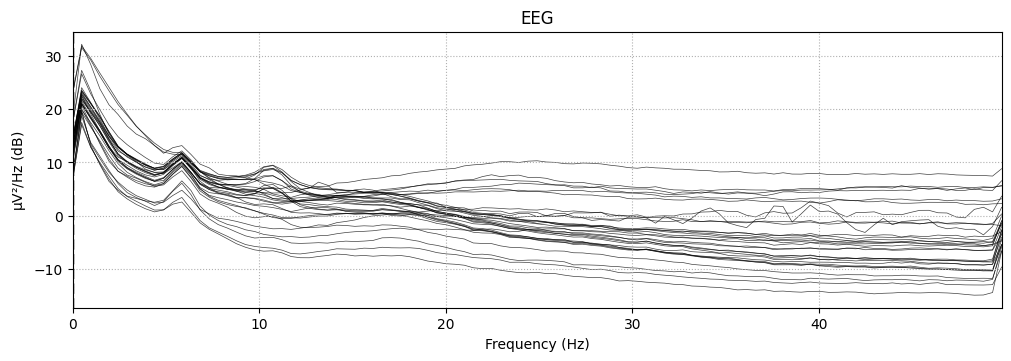

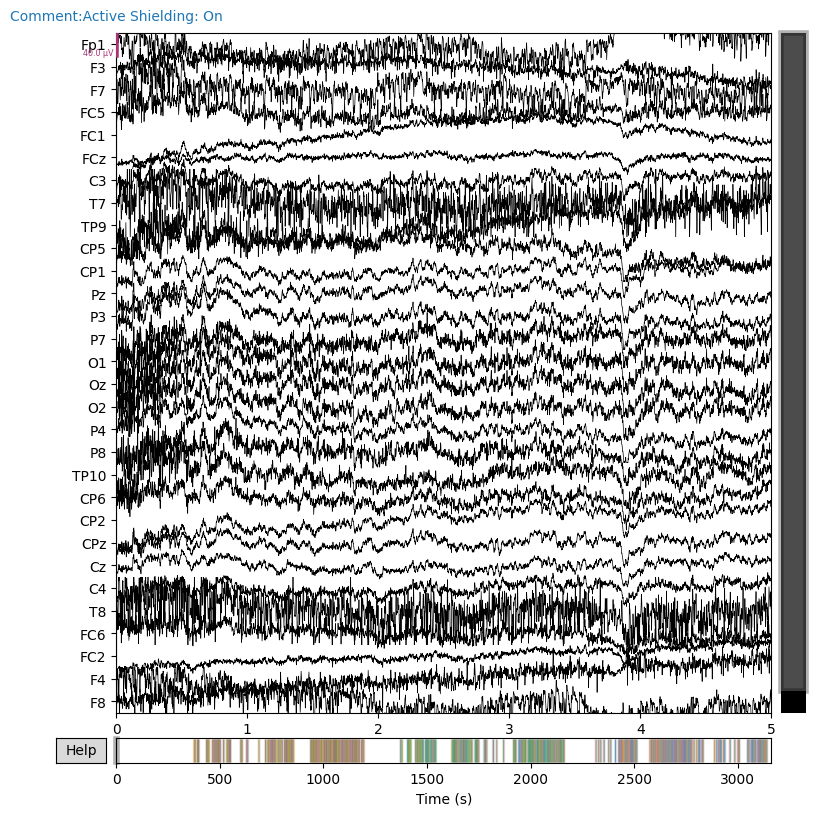

In [3]:
raw.compute_psd(fmax=50).plot(picks="data", exclude="bads", amplitude=False)
raw.plot(duration=5, n_channels=30);

# preprocessing

In [15]:
# from https://mne.discourse.group/t/no-valid-channel-positions-found/5458

from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)

montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)

print(raw.ch_names)

['Fp1', 'F3', 'F7', 'FC5', 'FC1', 'FCz', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'CPz', 'Cz', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'Fp2']


In [16]:
# apply filter on copy of raw
raw_f = raw.copy().filter(1,50, fir_design='firwin')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:    1.6s finished


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)


C:\Users\Max\AppData\Roaming\Python\Python311\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


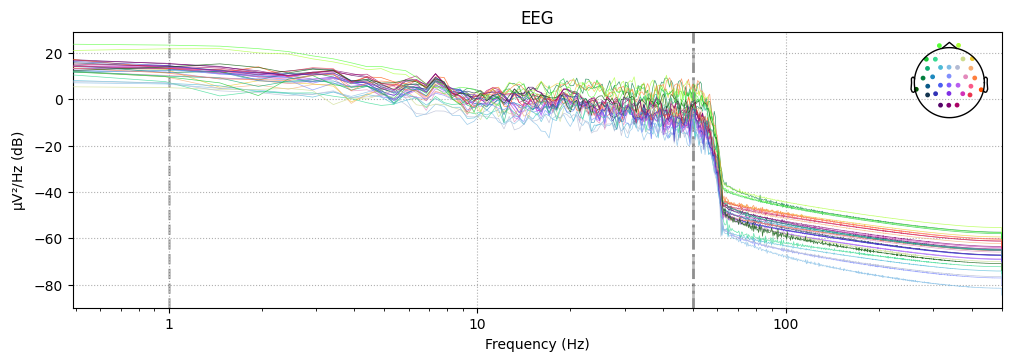

In [17]:
raw_f.plot_psd(area_mode='range', tmax=10.0, average=False, xscale='log')

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 36.9s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
1580 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1580 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1580 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1580 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1580 matching events found
No baseline correction applied
0 projection items activated


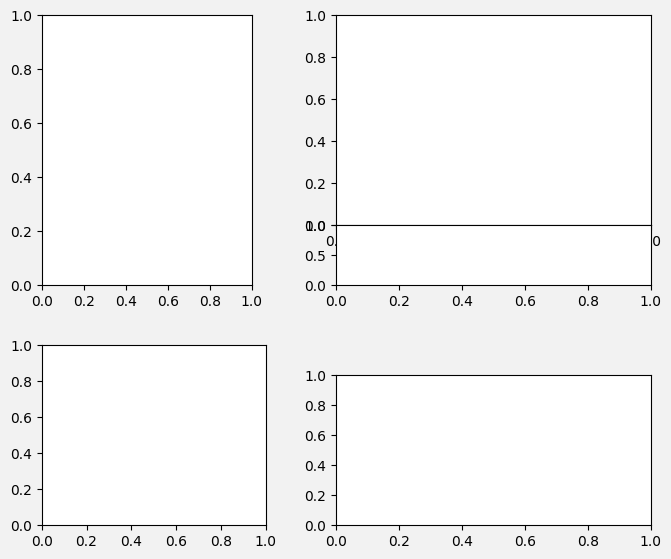

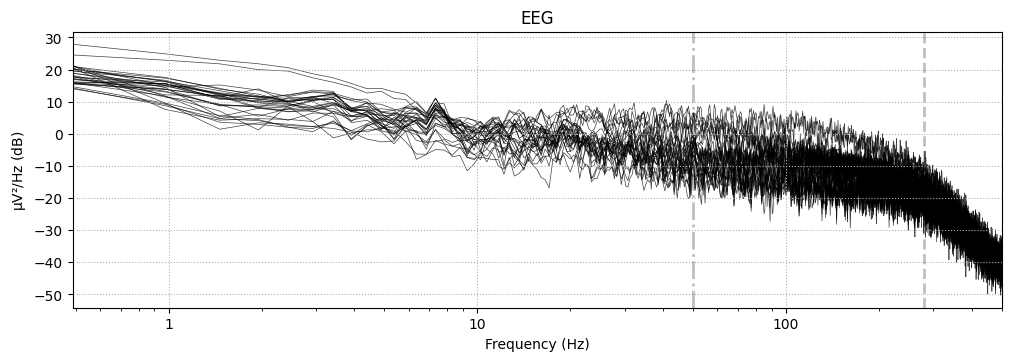

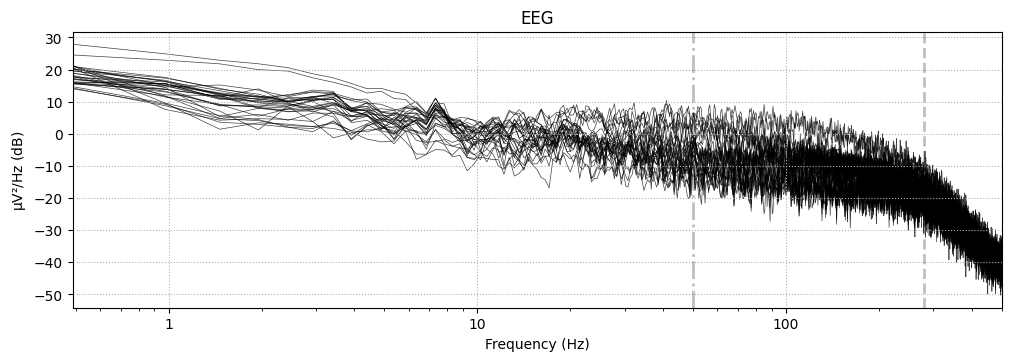

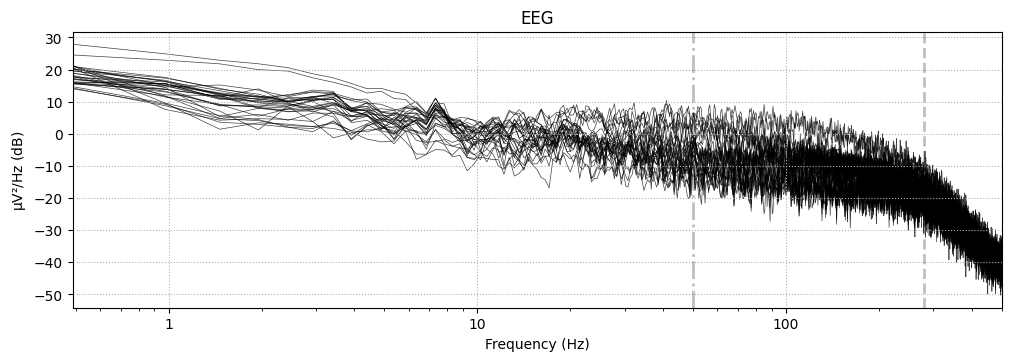

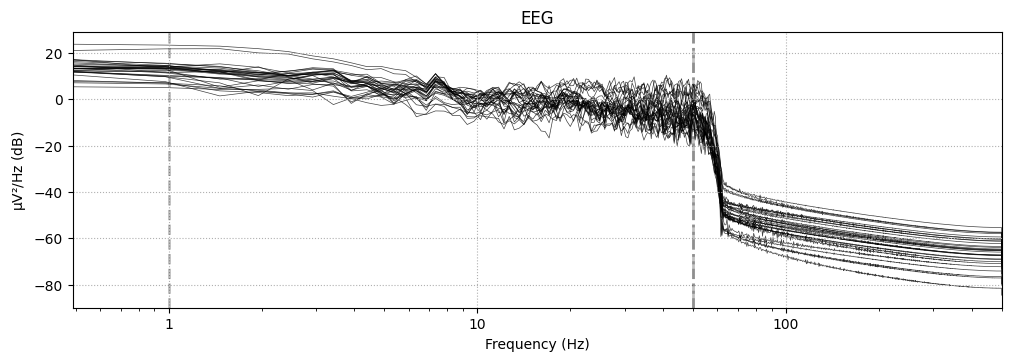

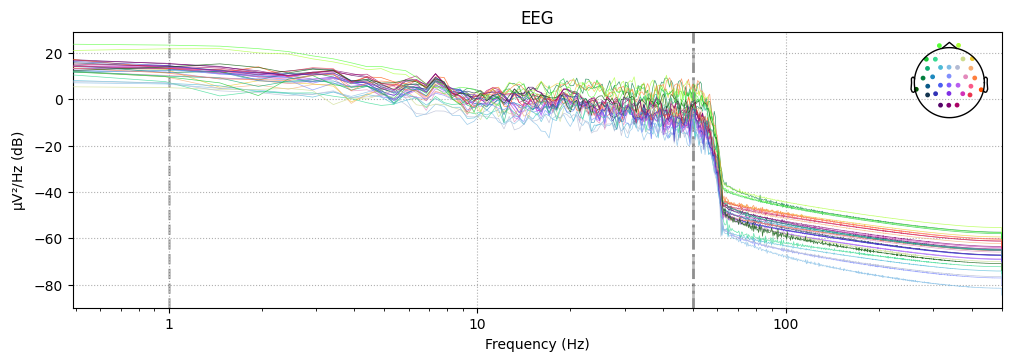

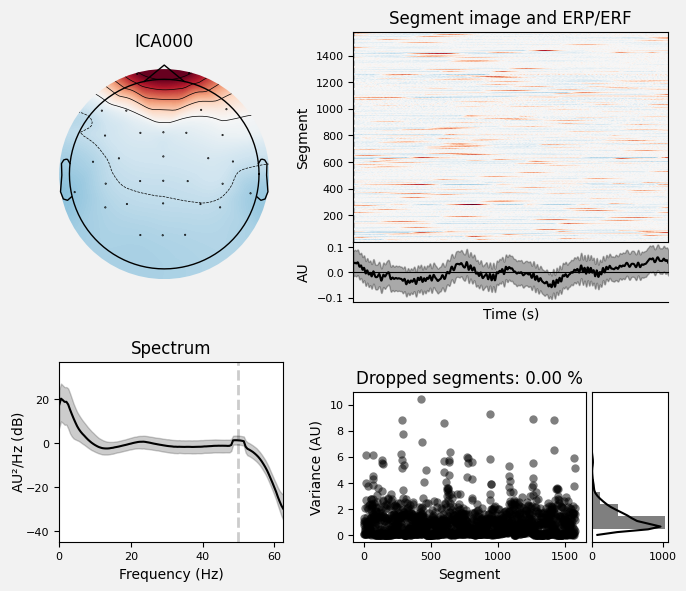

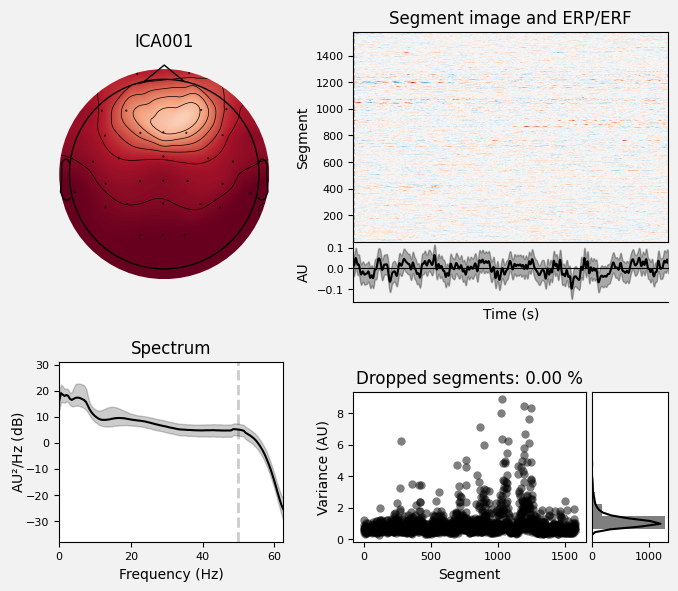

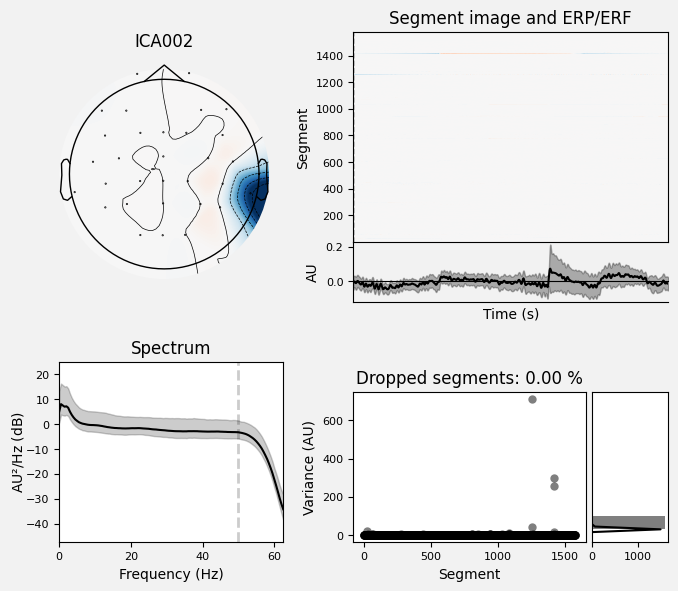

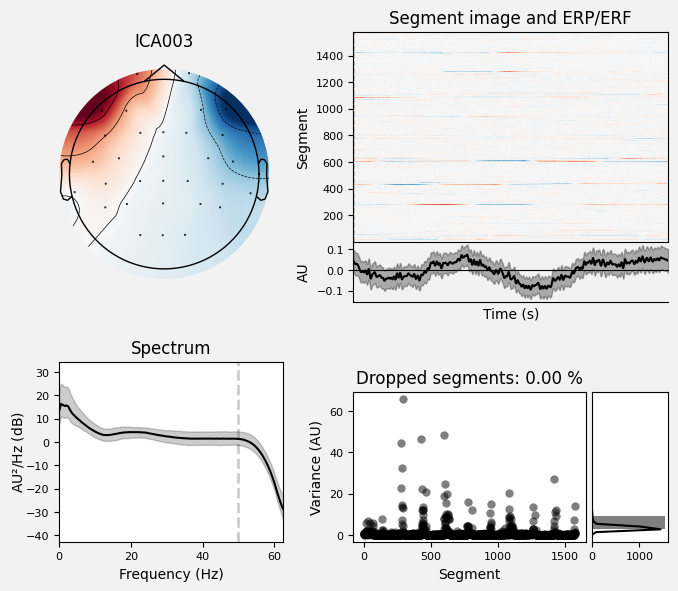

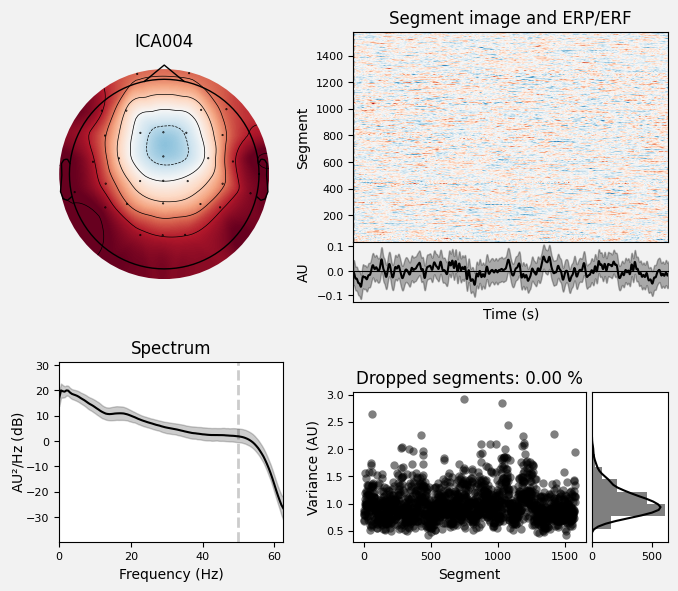

In [18]:
# set up and fit the ICA
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(raw_f)
ica.plot_properties(raw_f)

finding out more about selecting bad components later.. then adding steps
https://mne.tools/dev/auto_tutorials/intro/10_overview.html#:~:text=projection%20items%20activated-,Once,-we%E2%80%99re%20confident%20about

# finding events

does not work because we don't have a stim channel? not sure
see https://mne.tools/dev/auto_tutorials/intro/20_events_from_raw.html#stim-channel-defined:~:text=in%20MNE%2DPython.-,What%20is%20a%20STIM%20channel%3F,-%23

not sure how to initialize events yet, see
https://mne.tools/dev/auto_tutorials/intro/20_events_from_raw.html#tut-events-vs-annotations

In [24]:
# raw.copy().pick(picks="stim").plot(start=3, duration=6)

In [ ]:
# events = mne.find_events(raw, stim_channel="STI 014")
# print(events[:5])  # show the first 5

# epoching

In [21]:
reject_criteria = dict(
    mag=4000e-15,  # 4000 fT
    grad=4000e-13,  # 4000 fT/cm
    eeg=150e-6,  # 150 µV
    eog=250e-6,
)  # 250 µV

In [31]:
# epochs = mne.Epochs(
#     raw,
#     events,
#     event_id=event_dict,
#     tmin=-0.2,
#     tmax=0.5,
#     reject=reject_criteria,
#     preload=True,
# )